# Лабораторная работа 7. Понижение размерности. Отбор признаков. Извлечение признаков

В задачах машинного обучения практически всегда приходится иметь дело с данными, которые представлены **в пространствах высокой размерности**. Примеры:
- датафреймы с большим количеством столбцов (особенно после выполнения one-hot кодирования)
- пиксели изображения (особенно, если мы обрабатываем изображения классическими моделями)
- векторные представления слов / предложений / текстов (современные word2vec модели работают с пространствами размерности 300+)

**Понижение размерности - это** уменьшение количества признаков (переменных, столбцов) в наборе данных

## Для чего имеет смысл понижать размерность данных

Может показаться, что чем больше информации нам известно о данных, тем лучше и тем более качественные модели мы сможем построить, однако на практике это утверждение не работает. Можно привести следующие примеры, которые могут заставить задуматься о необходимости понижения размерности данных:
- работа с данными высокой размерности требует большого объема памяти и создает сильную нагрузку на процессор (каждый сталкивался с тем, что не получалось обучить модель на всем датасете после one-hot кодирования😀)
- высокая размерность данных может быть причиной переобучения моделей;
- решение задач кластеризации, а также других задач машинного обучения с помощью методов, основанных на анализе близости объектов (KMeans, DBSCAN, KNN, SVM и др.) может быть затруднено в виду так называемого **проклятия размерности** (Р. Беллман) - в пространствах высокой размерности все объекты кажутся одинаково близкими


А еще понижение размерности (в частности до 2 и 3 признаков) позволяет нам визуализировать сложные данные (в ML есть отдельная задача - визуализация данных)

**Существуют два подхода к понижению размерности данных:**
- отбор признаков (feature selection)
- выделение признаков (feature extraction)

Важно понимать, что в основе всех алгоритмов понижения размерности лежит понимание каждого признака как некоторой случайной величины. Если признаки зависят друг от друга, значит мы имеем дело с зависимыми случайными величинами. Данные в целом при таком подходе представляют собой совместное распределение нескольких случайных величин. **Цель понижения размерности: максимизация дисперсии (разброса) данных при переходе от высокой размерности к целевой.**

## Загрузка данных

Будем работать с уже знакомыми нам данными (банк)

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('bank_churners_preprocessed.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head()

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,c_F,c_M,c_Divorced,c_Married,c_Single,c_Unknown
0,0,45,3,2,3,0,39,5,1,3,...,1144,42,1.625,0.061,0,1,0,1,0,0
1,0,49,5,5,1,0,44,6,1,2,...,1291,33,3.714,0.105,1,0,0,0,1,0
2,0,51,3,5,4,0,36,4,1,0,...,1887,20,2.333,0.000,0,1,0,1,0,0
3,0,40,4,2,1,0,34,3,4,1,...,1171,20,2.333,0.760,1,0,0,0,0,1
4,0,40,3,1,3,0,21,5,1,0,...,816,28,2.500,0.000,0,1,0,1,0,0


In [ ]:
data = data.sort_values(by='Attrition_Flag', ascending=False)
data = data[:(data[data['Attrition_Flag'] == 1].shape[0]*2)]
data.shape

(3254, 24)

In [ ]:
data[data['Attrition_Flag'] == 0].shape, data[data['Attrition_Flag'] == 1].shape

((1627, 24), (1627, 24))

In [ ]:
data = data.sample(frac=1)

Набор данных содержит 24 признака. Будем пытаться понизить размерность

In [ ]:
X = data.drop(['Attrition_Flag'], axis=1)
y = data['Attrition_Flag']

Тестировать модель будем с помощью ансамбля

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
def test(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
  bag = BaggingClassifier().fit(X_train, y_train)
  print(classification_report(y_test, bag.predict(X_test)))

In [ ]:
import numpy as np

In [ ]:
np.random.seed(42)

In [ ]:
test(X, y)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       245
           1       0.99      1.00      0.99       244

    accuracy                           0.99       489
   macro avg       0.99      0.99      0.99       489
weighted avg       0.99      0.99      0.99       489



## 1. Отбор признаков

Отбор признаков предполагает, что мы удаляем из набора данных признаки, которые практически не несут в себе достаточно информации об объектах. **Мы оставляем в датасете только те признаки, которые раскрывают суть данных**. Мы рассмотрим несколько методов понижения размерности путем отбора признаков

### 1.1 Отбираем признаки с высокой дисперсией

Самый очевидный способ отбора признаков - брать признаки с высокой дисперсией. Такой подход предполагает, что мы работаем только с предикторами (игнорируем целевой признак)

In [ ]:
X.describe()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,c_F,c_M,c_Divorced,c_Married,c_Single,c_Unknown
count,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,...,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000
mean,46.766749,2.413337,2.889367,1.890596,0.076521,36.280578,3.750461,2.555931,2.559312,7212.709004,...,4012.848187,61.529809,0.657285,0.253836,0.625077,0.374923,0.077443,0.430854,0.414567,0.077136
std,7.371566,1.285434,1.990770,1.417368,0.330788,7.530996,1.550401,1.012574,1.080534,8405.128963,...,2257.919060,21.237771,0.216947,0.293958,0.484177,0.484177,0.267334,0.495272,0.492723,0.266848
min,26.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,...,510.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,1.250000,1.000000,1.000000,0.000000,32.000000,3.000000,2.000000,2.000000,2140.250000,...,2326.000000,43.000000,0.516000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.000000,2.000000,3.000000,1.000000,0.000000,36.000000,4.000000,3.000000,3.000000,3412.000000,...,4096.000000,65.000000,0.674000,0.110500,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,3.000000,5.000000,3.000000,0.000000,40.000000,5.000000,3.000000,3.000000,8593.500000,...,4766.500000,79.000000,0.795750,0.502750,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,68.000000,5.000000,6.000000,5.000000,3.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,...,15999.000000,127.000000,2.500000,0.999000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Напоминаю, что дисперсия равна квадрату std

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# параметр - порог значения дисперсии
# будут отобраны только те признаки, у которых дисперсия выше
vt = VarianceThreshold(2)
X_vt = vt.fit_transform(X)
X_vt.shape

(3254, 10)

In [ ]:
X_vt = pd.DataFrame(X_vt, columns=vt.get_feature_names_out())
X_vt.head()

,Customer_Age,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct
0,42.0,3.0,2.0,30.0,5.0,1438.3,1223.0,215.3,2181.0,43.0
1,46.0,2.0,2.0,37.0,6.0,2375.0,1196.0,1179.0,4087.0,66.0
2,50.0,6.0,0.0,36.0,5.0,4045.0,0.0,4045.0,2438.0,41.0
3,41.0,0.0,2.0,25.0,4.0,4277.0,2186.0,2091.0,8764.0,69.0
4,37.0,0.0,1.0,27.0,6.0,3061.0,2517.0,544.0,5032.0,89.0


Все модели для понижения размерности, как правило, реализуют общий интерфейс: fit + transform. На этапе fit модель "обучается" (считаются статистические функции, различные матрицы преобразования и т.д.). На этапе transform выполняется преобразование данных. При выполнении метода fit_transform модель сразу же "обучается" и выполняет преобразование данных

In [ ]:
test(X_vt, y)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       245
           1       0.98      0.99      0.98       244

    accuracy                           0.98       489
   macro avg       0.98      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



Обратите внимание, что у нас данные не нормированы, в следствие чего дисперсия отдельных признаков может различаться на порядки. При использовании рассматриваемой стратегии отбора признаков обычно производится масштабирование данных

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,c_F,c_M,c_Divorced,c_Married,c_Single,c_Unknown
0,-0.646739,-1.877739,0.055582,0.077200,-0.231365,-0.834092,0.806070,-0.549112,0.407906,-0.687116,...,-0.811424,-0.872627,-0.296361,2.028368,0.774470,-0.774470,-0.289731,-0.870069,1.188342,-0.289107
1,-0.104030,2.012597,-0.446814,0.077200,-0.231365,0.095543,1.451163,-0.549112,-1.443315,-0.575655,...,0.032846,0.210515,0.810068,0.851149,-1.291206,1.291206,-0.289731,1.149335,-0.841508,-0.289107
2,0.438679,-0.321604,1.562768,-1.334084,-0.231365,-0.037262,0.806070,-0.549112,1.333516,-0.376936,...,-0.697585,-0.966814,-0.891067,-0.863644,0.774470,-0.774470,-0.289731,1.149335,-0.841508,-0.289107
3,-0.782417,-0.321604,-1.451605,0.077200,-0.231365,-1.498117,0.160976,-0.549112,0.407906,-0.349330,...,2.104540,0.351795,0.118550,0.874965,-1.291206,1.291206,3.451478,-0.870069,-0.841508,-0.289107
4,-1.325125,-0.321604,-1.451605,-0.628442,-0.231365,-1.232507,1.451163,-1.536846,0.407906,-0.494025,...,0.451437,1.293658,-0.181108,1.933101,0.774470,-0.774470,-0.289731,-0.870069,1.188342,-0.289107


In [ ]:
vt = VarianceThreshold(1)
X_vt = vt.fit_transform(X_scaled)
print(X_vt.shape)
test(X_vt, y)

(3254, 8)
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       245
           1       0.97      0.98      0.97       244

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489



В данном случае видим, что качество полученных моделей не сильно уменьшилось - но посмотрите насколько уменьшилась размерность. Более чем в два раза в обоих случаях! При этом, возможно, было переобучение, и мы боремся с ним понимая размерность.

### 1.2 Одномерный отбор признаков

Одномерный отбор признаков предполагает, что для каждого признака оценивается степень его влияния на целевую переменную. Признаки с небольшим влиянием удаляются. В качестве оценки обычно используются статистические тесты (чаще всего [тест Фишера](https://ru.wikipedia.org/wiki/F-%D1%82%D0%B5%D1%81%D1%82))

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
skb = SelectKBest(k=6)
X_skb = skb.fit_transform(X, y)
test(X_skb, y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       245
           1       0.99      0.99      0.99       244

    accuracy                           0.99       489
   macro avg       0.99      0.99      0.99       489
weighted avg       0.99      0.99      0.99       489



In [ ]:
X_skb = pd.DataFrame(X_skb, columns=skb.get_feature_names_out())
X_skb

,Total_Relationship_Count,Contacts_Count_12_mon,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,5.0,3.0,2181.0,43.0,0.593,0.850
1,6.0,1.0,4087.0,66.0,0.833,0.504
2,5.0,4.0,2438.0,41.0,0.464,0.000
3,4.0,3.0,8764.0,69.0,0.683,0.511
4,6.0,3.0,5032.0,89.0,0.618,0.822
...,...,...,...,...,...,...
3249,5.0,2.0,3691.0,77.0,0.510,0.000
3250,6.0,2.0,8642.0,77.0,0.481,0.000
3251,1.0,3.0,8688.0,69.0,0.769,0.087
3252,3.0,2.0,4220.0,79.0,0.612,0.811


### 1.3 Рекурсивный отбор признаков

Рекурсивный отбор признаков предполагает обучение множества моделей. Сначала модель обучается на всех признаках, а затем мы начинаем исключать из модели признаки с низкой значимостью. Делаем это до тех пор, пока не останется столько признаков, сколько нам нужно получить

Важный момент состоит в том, каким образом мы исключаем признаки. Происходит это на основе значения значимости признака. Обученные регрессионные модели и деревья решений хранят информацию о значимости признаков (коэффициенты в линейных моделях и значения значимости признаков у деревьев). Можно отсортировать признаки по этим значениям и производить отбор

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier().fit(X, y)

In [ ]:
rfe = RFE(estimator=tree, n_features_to_select=4, step=1).fit(X, y)
X_rfe = pd.DataFrame(rfe.transform(X), columns=rfe.get_feature_names_out())
X_rfe

,Total_Relationship_Count,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1
0,5.0,2181.0,43.0,0.593
1,6.0,4087.0,66.0,0.833
2,5.0,2438.0,41.0,0.464
3,4.0,8764.0,69.0,0.683
4,6.0,5032.0,89.0,0.618
...,...,...,...,...
3249,5.0,3691.0,77.0,0.510
3250,6.0,8642.0,77.0,0.481
3251,1.0,8688.0,69.0,0.769
3252,3.0,4220.0,79.0,0.612


In [ ]:
test(X_rfe, y)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       245
           1       0.98      0.98      0.98       244

    accuracy                           0.98       489
   macro avg       0.98      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



Бум! Осталось 4 признака, а модель все еще могЁт!

### 1.4 Отбор признаков по их значимости

Во многих случаях можно не использовать рекурсивный отбор, а просто взять обученное дерево и сразу же взять нужное количество признаков с самой высокой значимостью

In [ ]:
import matplotlib.pyplot as plt

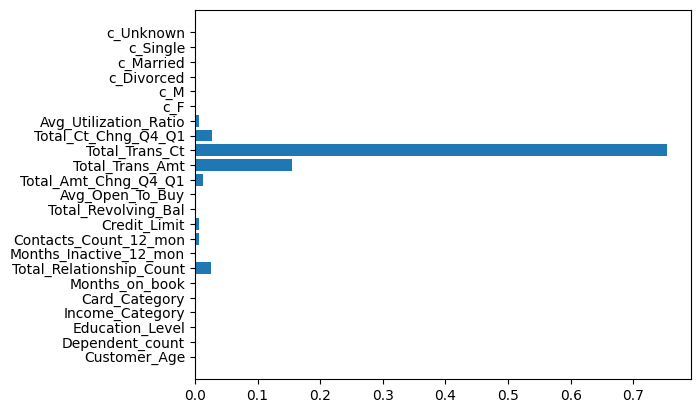

In [ ]:
plt.barh(width=tree.feature_importances_, y=X.columns);

Напомню еще раз, что при решении задачи регрессии с использованием линейных моделей мы можем в качестве оценки значимости признака использовать коэффициенты. Вы будете использовать этот факт при выполнении задания.

## 2. Выделение признаков

В отличие от отбора признаков, когда мы исключаем из датасета ненужные признаки, при выделении **мы производим преобразование данных из пространства высокой размерности в пространство низкой размерности**. Важно понимать, что при таком подходе по сути мы вводим "новые оси". Это означает, что признаки в целевом пространстве мы уже не сможем интерпретировать

### 2.1 Метод главных компонент

Метод главных компонент (Principal Component Analysis - PCA) - это один из наиболее часто используемых методов извлечения признаков, который вам потребуется реализовать самостоятельно.

Чтобы выполнить понижение размерности методом PCA необходимо последовательно выполнить следующие действия.

1. Стандартизация данных (итерируемся по столбцам, от каждого элемента столбца отнимаем среднее по столбцу и делим на отклонение столбца - то, что делает StandartScaller).
2. Вычисление ковариационной матрицы.
3. Вычисление собственных векторов и собственных значений ковариационной матрицы.
4. Сортировка пар <собственное значение, собственный вектор> по убыванию.
5. Выбор первых k пар <собственное значение, собственный вектор>, где k - размерность целевого пространства.
6. Матрица, составленная из k собственных векторов - матрица преобразования из данного пространства в пространство с размерностью k.
7. Чтобы произвести понижение размерности необходимо умножить матрицу стандартизированных входных данных (результат пункта 1) на матрицу из k собственных векторов (результат пункта 6).

На основе пункта 7 можно сделать, что PCA - линейный метод понижения размерности

Собственные значения и вектора можно посчитать с помощью numpy в одну строку

При работе с numpy **следите за размерностью**. Имейте в виду, что в некоторых местах придется выполнять транспонирование матриц, даже если оно не предусмотрено в формулах (в виду особенностей представления матриц в numpy)

Более подробно:
- https://habr.com/ru/articles/304214/
- https://www.turing.com/kb/guide-to-principal-component-analysis (вот здесь прям формулы, которые рекомендуется использовать)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)
X_pca.shape

(3254, 2)

Данные имеют размерность 2 - их можно визуализировать

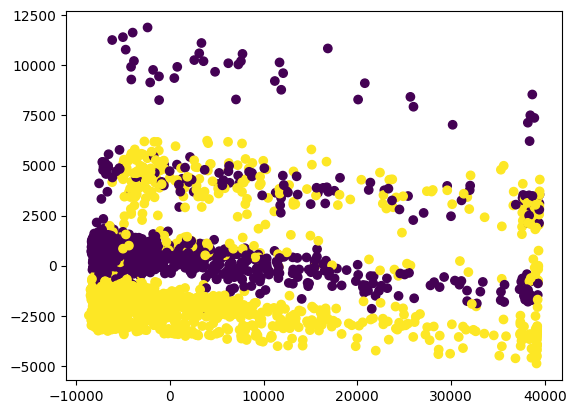

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y);

Мы понизили размерность до 2 признаков, и теперь имеет смысл оценить, сколько информации мы потеряли

In [ ]:
sum(pca.explained_variance_ratio_)

0.9924448371305413

Видно, что мы сохранили более 99% информации понизив размерность до 2 - попробуем выполнить классификацию

In [ ]:
test(X_pca, y)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       245
           1       0.96      0.89      0.92       244

    accuracy                           0.92       489
   macro avg       0.93      0.92      0.92       489
weighted avg       0.93      0.92      0.92       489



Качестве классификации понизилось, но при этом мы получили данные с размерностью 2!

In [ ]:
pca_2 = PCA(n_components=3)
X_pca_2 = pca_2.fit_transform(X, y)

In [ ]:
test(X_pca_2, y)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       245
           1       0.97      0.90      0.93       244

    accuracy                           0.94       489
   macro avg       0.94      0.94      0.94       489
weighted avg       0.94      0.94      0.94       489



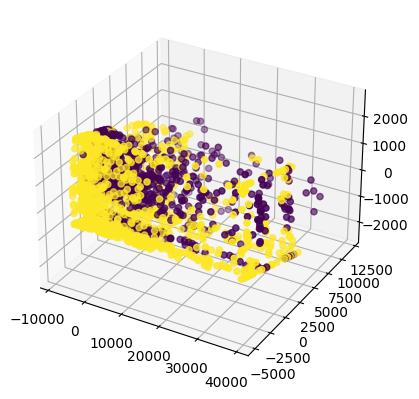

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_pca_2[:,0], X_pca_2[:,1], X_pca_2[:,2], c=y);

### 2.2 Нелинейные методы выделения признаков

Нелинейные методы понижения размерности предполагают, что данные должны быть расположены на нелинейной поверхности меньшей размерности, чем исходное пространство

Полезные материалы:
- https://habr.com/ru/articles/267041/
- https://medium.com/nuances-of-programming/%D0%B4%D0%BE%D1%85%D0%BE%D0%B4%D1%87%D0%B8%D0%B2%D0%BE-%D0%BE%D0%B1-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B8-%D0%BD%D0%B0-%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5-%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%B8%D0%B9-%D1%81-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B0%D0%BC%D0%B8-isomap-t-sne-%D0%B8-lle-8fbb30851953
- https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0

Распространены такие алгоритмы, как t-SNE (t-distributed Stochastic Neighbor Embedding) и Isomap. Существует при этом множество других алгоритмов

In [ ]:
from sklearn.manifold import TSNE, Isomap

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

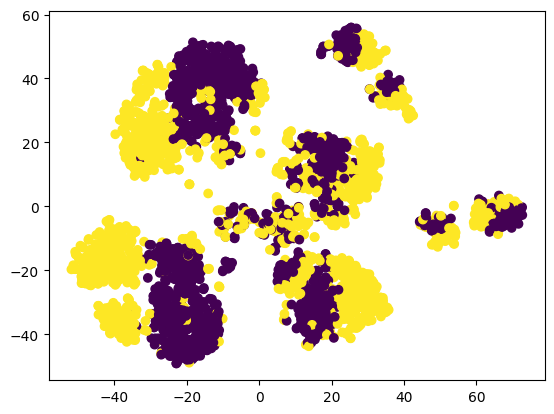

In [ ]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y);

In [ ]:
test(X_tsne, y)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       245
           1       0.93      0.88      0.90       244

    accuracy                           0.91       489
   macro avg       0.91      0.91      0.91       489
weighted avg       0.91      0.91      0.91       489



In [ ]:
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)

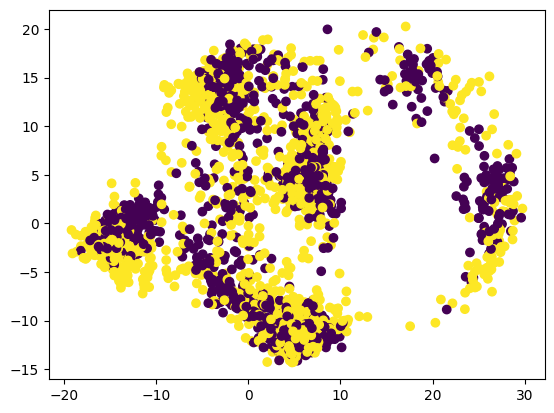

In [ ]:
plt.scatter(X_isomap[:,0], X_isomap[:,1], c=y);

Попробуем применить к результату tSNE алгоритм KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


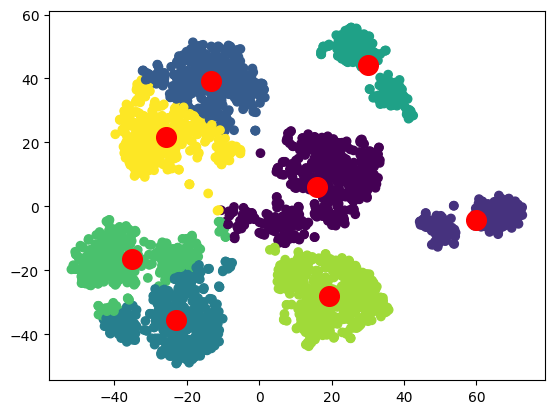

In [ ]:
kmeans = KMeans(n_clusters=8).fit(X_tsne)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=200);

In [ ]:
silhouette_score(X_tsne, kmeans.labels_)

0.5069558

Результат классификации - **клиентов банка можно разделить на 8 групп**, которые достаточно сильно отличаются друг от друга. Этот факт может быть использован, например если банк захочет каждой группе предлагать определенные услуги. Интерпретация групп является задачей исследователя

**Понижение размерности в машинном обучении играет очень важную роль**, поскольку оптимизирует вычислительные затраты, дает возможность визуализировать данные и позволяет избежать "проклятия размерности"

## Задания

1. Используйте **наборы данных для классификации и регрессии**, с помощью которых вы выполняли ЛР1-ЛР4.
2. С помощью классов библиотеки sklearn выполните понижение размерности (**размерность выберите сами, можно разные**) с использованием всех описанных методов (VarianceThreshold, SelectKBest, RFE, PCA, tSNE, Isomap).
3. **Выберите две модели** (одна - для регрессии и другая - для классификации).
4. Обучите выбранные модели с использованием данных в пространстве низкой размерности - **используйте результаты выполнения пункта 3** (не забудьте, что понижать нужно и X_train и X_test - проще всего понижать X). **Сделайте вывод** о том, какие методы понижения размерности лучше всего подходят для ваших данных.
5. **Самостоятельно реализуйте алгоритм PCA**. Выполните с его помощью понижение размерности датасета для классификации до 2 (преобразуйте данные в двумерное пространство). **Выполните визуализацию данных** (точки на плоскости).
6. Попробуйте выполнить **кластеризацию преобразованных в пункте 5 данных с помощью вашей реализации алгоритма KMeans** из ЛР6.
7. Используйте оригинальный датасет для регрессии (без понижения размерности). Обучите любую из линейных моделей, реализованных вами в ЛР1. **Важно: модель должна быть реализована вами, не sklearn!** Посмотрите значения коэффициентов модели, выберите несколько признаков с наибольшими значениями коэффициентов.


In [2]:
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from category_encoders.binary import BinaryEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
from math import sqrt
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

In [3]:
data = pd.read_csv('../data/regression/moldova_cars_task.csv')

In [7]:
data.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0


In [4]:
data2 = pd.read_csv('../data/classification/airlines_task.csv')

In [8]:
data2.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,400740,XE,3036,IAH,CHS,4.0,1195,131.0,0
1,194808,UA,315,DEN,ONT,7.0,707,145.0,0
2,526903,OO,6673,SFO,MRY,5.0,499,42.0,1
3,477937,WN,3668,PHX,ONT,2.0,810,70.0,1
4,48180,AS,623,LAS,PDX,5.0,985,143.0,0


In [5]:
data.shape


(41007, 9)

In [6]:
data2.shape

(400000, 9)

In [5]:
def test(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
  bag = BaggingClassifier().fit(X_train, y_train)
  print(classification_report(y_test, bag.predict(X_test)))

In [6]:
def test2(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
  bag = BaggingClassifier().fit(X_train, y_train)
  y_pred = bag.predict(X_test)
  print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
  print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
  print(f'MSE: {mean_squared_error(y_test, y_pred)}')
  print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
  print(f'MAPE: {(mean_absolute_percentage_error(y_test, y_pred))}')
  print(f'R^2: {r2_score(y_test, y_pred)}')

In [7]:
X = data.drop('Price(euro)', axis=1)
y = data['Price(euro)']
X['Model'] = X['Model'].fillna(X['Model'].mode()[0])
X['Distance'] = X['Distance'].fillna(X['Distance'].mean())
X['Year'] = X['Year'].fillna(X['Year'].mean())
X['Transmission'] = X['Transmission'].fillna(X['Transmission'].mode()[0])
X = pd.get_dummies(X,columns=['Transmission','Fuel_type'])
X = X.drop('Style',axis=1)
X = X.drop('Model',axis=1)
bn = BinaryEncoder()
X = bn.fit_transform(X)

In [8]:

data2['Airline'] = data2['Airline'].fillna(data2['Airline'].mode()[0])
data2['AirportTo'] = data2['AirportTo'].fillna(data2['AirportTo'].mode()[0])
data2['DayOfWeek'] = data2['DayOfWeek'].fillna(data2['DayOfWeek'].mean())
data2['Length'] = data2['Length'].fillna(data2['Length'].mode()[0])
X1= data2.drop('Delay', axis=1)
y1 = data2['Delay'] 
bn = LabelEncoder()
X1['Airline'] = bn.fit_transform(X1['Airline'])
X1['AirportFrom'] =  bn.fit_transform(X1['Airline'])
X1['AirportTo'] = bn.fit_transform(X1['AirportTo'])
scaler = MinMaxScaler()
scaler.fit(X1[["DayOfWeek","Time","Length"]])
X1[["DayOfWeek","Time","Length"]]= scaler.transform(X1[["DayOfWeek","Time","Length"]])


In [18]:
test(X1, y1)

              precision    recall  f1-score   support

           0       0.85      0.90      0.88     44806
           1       0.65      0.54      0.59     15194

    accuracy                           0.81     60000
   macro avg       0.75      0.72      0.73     60000
weighted avg       0.80      0.81      0.80     60000



In [33]:
test2(X, y)

MAE: 4235.218953185956
MAE: 4235.218953185956
MSE: 16284673240.366222
RMSE: 127611.41500808705
MAPE: 0.5250415124852922
R^2: 0.0020347245620216947


In [36]:
X.describe()

,Make_0,Make_1,Make_2,Make_3,Make_4,Make_5,Make_6,Year,Distance,Engine_capacity(cm3),Transmission_Automatic,Transmission_Manual,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid
count,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000,4.100700e+04,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000,41007.000000
mean,0.002585,0.059697,0.261614,0.291755,0.383252,0.525983,0.574853,2007.979152,4.571171e+05,1853.856732,0.450947,0.549053,0.460946,0.008267,0.053479,0.109542,0.354964,0.012803
std,0.050777,0.236928,0.439519,0.454576,0.486185,0.499330,0.494371,8.222605,4.451526e+06,700.364532,0.497594,0.497594,0.498479,0.090547,0.224989,0.312322,0.478508,0.112424
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2004.000000,8.800000e+04,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2009.000000,1.688620e+05,1800.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2014.000000,2.300000e+05,2000.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2021.000000,1.000000e+08,9999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
X1.describe()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,287779.723357,9.227615,2455.453042,9.227615,142.455925,0.492171,0.544197,0.200012
std,163738.931168,5.294688,2078.725805,5.294688,79.268264,0.307481,0.197848,0.105877
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,139979.750000,5.000000,710.000000,5.000000,79.000000,0.333333,0.370889,0.123664
50%,296098.500000,10.000000,1848.000000,10.000000,148.000000,0.500000,0.535339,0.175573
75%,439381.250000,14.000000,3793.250000,14.000000,208.000000,0.666667,0.710287,0.244275
max,539381.000000,17.000000,7813.000000,17.000000,292.000000,1.000000,1.000000,1.000000


In [44]:
vt = VarianceThreshold(1)
X_vt = vt.fit_transform(X)
X_vt.shape

(41007, 3)

In [45]:
X_vt = pd.DataFrame(X_vt, columns=vt.get_feature_names_out())
X_vt.head()

,Year,Distance,Engine_capacity(cm3)
0,2011.0,195000.0,1800.0
1,2014.0,135000.0,1500.0
2,1998.0,1.0,1400.0
3,2012.0,110000.0,1500.0
4,2006.0,200000.0,1600.0


In [46]:
test2(X_vt, y)

MAE: 4792.700422626788
MAE: 4792.700422626788
MSE: 16296797003.599968
RMSE: 127658.90882974038
MAPE: 0.6344405321265251
R^2: 0.0012917501997902203


In [50]:
vt = VarianceThreshold(1)
X_vt = vt.fit_transform(X1)
X_vt.shape

(400000, 5)

In [52]:
X_vt = pd.DataFrame(X_vt, columns=vt.get_feature_names_out())
X_vt.head()

,id,Airline,Flight,AirportFrom,AirportTo
0,400740.0,16.0,3036.0,16.0,54.0
1,194808.0,13.0,315.0,13.0,207.0
2,526903.0,12.0,6673.0,12.0,194.0
3,477937.0,15.0,3668.0,15.0,207.0
4,48180.0,2.0,623.0,2.0,214.0


In [54]:
test(X_vt, y1)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87     44806
           1       0.63      0.53      0.58     15194

    accuracy                           0.80     60000
   macro avg       0.74      0.71      0.73     60000
weighted avg       0.80      0.80      0.80     60000



In [56]:
skb = SelectKBest(k=6)
X_skb = skb.fit_transform(X, y)
test2(X_skb, y)

MAE: 4609.44066970091
MAE: 4609.44066970091
MSE: 16267314774.185793
RMSE: 127543.38389028964
MAPE: 0.5927683841502078
R^2: 0.0030984945393026653


In [58]:
skb = SelectKBest(k=6)
X_skb = skb.fit_transform(X1, y1)
test(X_skb, y1)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87     44806
           1       0.64      0.53      0.58     15194

    accuracy                           0.80     60000
   macro avg       0.74      0.72      0.73     60000
weighted avg       0.80      0.80      0.80     60000



In [70]:
tree1 = DecisionTreeClassifier().fit(X, y)
rfe = RFE(estimator=tree1, n_features_to_select=4, step=1).fit(X, y)
X_rfe = pd.DataFrame(rfe.transform(X), columns=rfe.get_feature_names_out())
X_rfe

,Make_5,Year,Distance,Engine_capacity(cm3)
0,0.0,2011.0,195000.0,1800.0
1,1.0,2014.0,135000.0,1500.0
2,1.0,1998.0,1.0,1400.0
3,1.0,2012.0,110000.0,1500.0
4,0.0,2006.0,200000.0,1600.0
...,...,...,...,...
41002,1.0,2015.0,89000.0,1500.0
41003,1.0,2009.0,225.0,1500.0
41004,0.0,2016.0,50000.0,1950.0
41005,1.0,2006.0,370000.0,2000.0


In [63]:
test2(X_rfe, y)

MAE: 4667.159622886866
MAE: 4667.159622886866
MSE: 16286113436.682705
RMSE: 127617.05778101415
MAPE: 0.5961845422555994
R^2: 0.0019464657500425364


In [64]:
tree = DecisionTreeClassifier().fit(X1, y1)
rfe = RFE(estimator=tree, n_features_to_select=4, step=1).fit(X1, y1)
X_rfe = pd.DataFrame(rfe.transform(X1), columns=rfe.get_feature_names_out())
X_rfe

,id,Flight,AirportTo,Length
0,400740.0,3036.0,54.0,0.200000
1,194808.0,315.0,207.0,0.221374
2,526903.0,6673.0,194.0,0.064122
3,477937.0,3668.0,207.0,0.106870
4,48180.0,623.0,214.0,0.218321
...,...,...,...,...
399995,488611.0,1533.0,80.0,0.229008
399996,188847.0,486.0,217.0,0.163359
399997,437638.0,3111.0,184.0,0.128244
399998,98020.0,623.0,80.0,0.335878


In [65]:
test(X_rfe, y1)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86     44806
           1       0.60      0.48      0.54     15194

    accuracy                           0.79     60000
   macro avg       0.72      0.69      0.70     60000
weighted avg       0.78      0.79      0.78     60000



<BarContainer object of 8 artists>

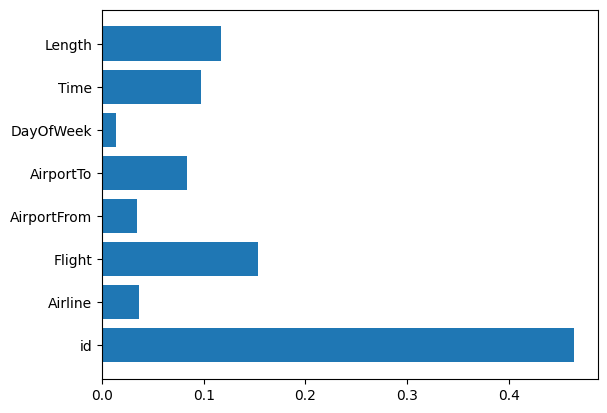

In [69]:
plt.barh(width=tree.feature_importances_, y=X1.columns)

<BarContainer object of 18 artists>

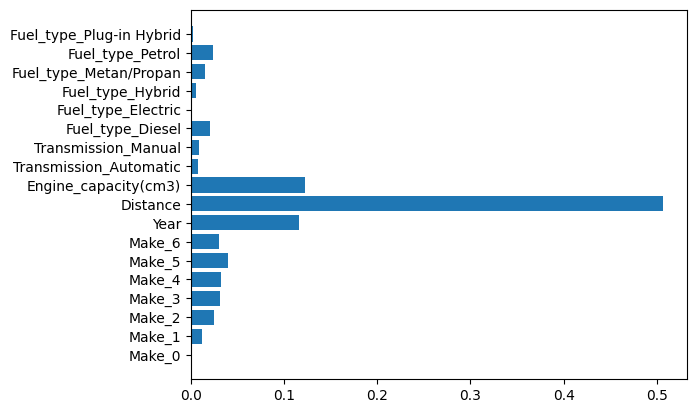

In [71]:
plt.barh(width=tree1.feature_importances_, y=X.columns)

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)
X_pca.shape

(41007, 2)

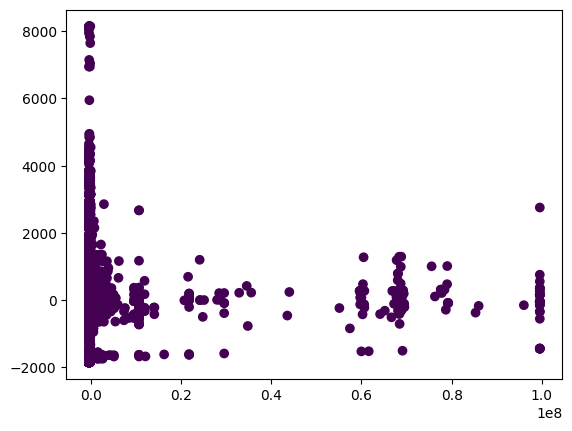

In [16]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)


In [17]:
sum(pca.explained_variance_ratio_)

0.9999999999965008

In [20]:
test2(X_pca, y)

MAE: 6048.85744473342
MAE: 6048.85744473342
MSE: 16377656208.55803
RMSE: 127975.21716550447
MAPE: 1.1515672257410074
R^2: -0.003663502973337174


In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X1, y1)
X_pca.shape

(400000, 2)

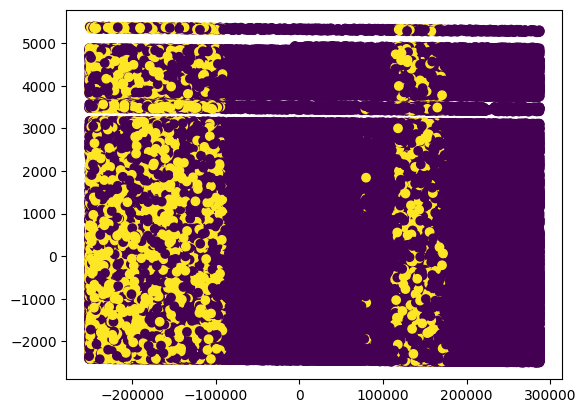

In [22]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y1)

In [23]:
sum(pca.explained_variance_ratio_)

0.9999997637518385

In [24]:
test(X_pca, y1)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     44806
           1       0.55      0.47      0.51     15194

    accuracy                           0.77     60000
   macro avg       0.69      0.67      0.68     60000
weighted avg       0.76      0.77      0.76     60000



In [27]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

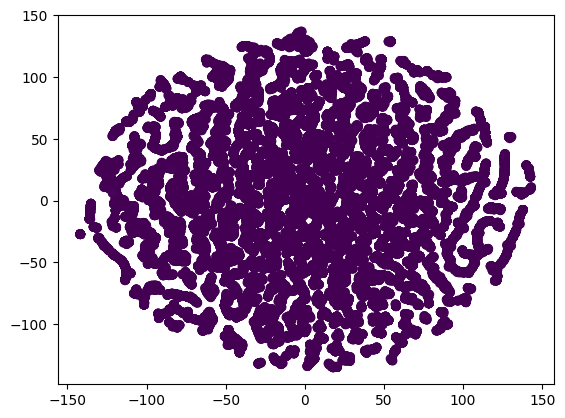

In [28]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)

In [29]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X1)

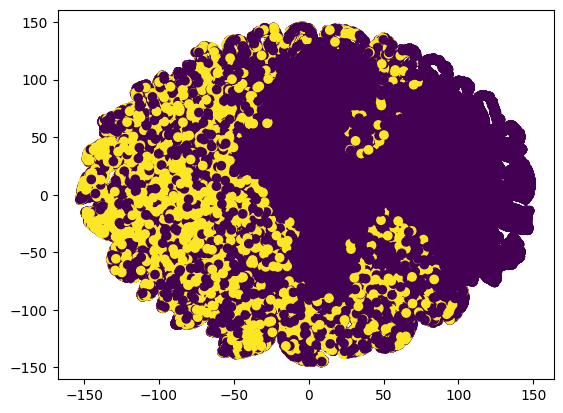

In [36]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y1)

In [33]:
sum(pca.explained_variance_ratio_)

0.9999997637518385

In [34]:
test2(X_pca, y1)

MAE: 0.23096666666666665
MAE: 0.23096666666666665
MSE: 0.23096666666666665
RMSE: 0.4805899152777414
MAPE: 438950843681044.44
R^2: -0.22135948868381683


In [10]:
from pathlib import Path
import os
import sys
sys.path.append(str(Path(os.getcwd()).parent))
from src.Clustering.KMeans import myKMeans
from src.regression.Ridge import Ridges
from src.ponizenie.PCA import pca

In [11]:
o = pca(X1,2)

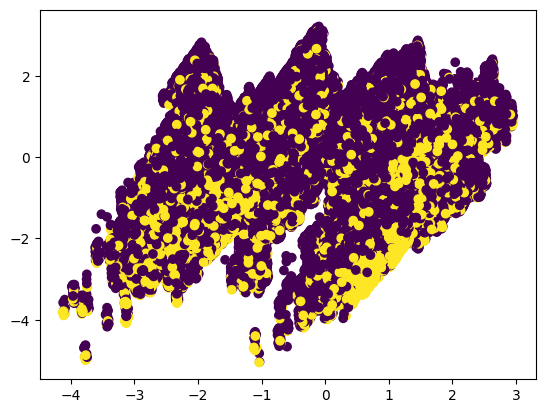

In [13]:
plt.scatter(o[:,0], o[:,1], c=y1)

In [28]:
y_pred = myKMeans(n_clusters=4)
y_pred.fit(o)
labels = y_pred.predict(o)

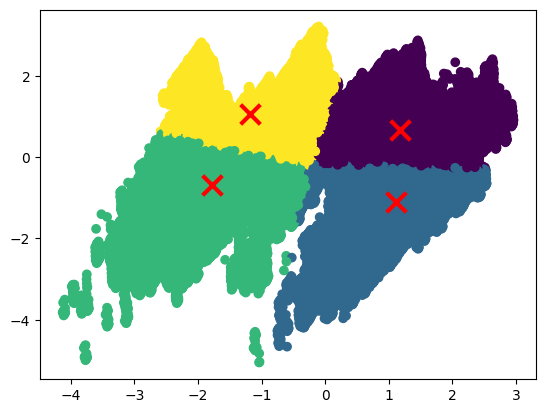

In [29]:
plt.scatter(o[:, 0], o[:, 1], c=labels, cmap='viridis')
plt.scatter(y_pred.centroids[:, 0], y_pred.centroids[:, 1], marker='x', s=200, linewidths=3, color='r')
plt.show()

In [23]:
ypred = Ridge().fit(X,y)
ypred = ypred.coef_
print(ypred)

[ 9.40118747e+04  2.95966150e+02 -9.26064069e+02  2.41622675e+02
  1.28374947e+03 -8.65581706e+02  1.50325911e+03  5.35391219e+02
  6.60381145e-06  4.03616967e+00  1.83011876e+03 -1.83011876e+03
 -1.15454398e+03  4.61719015e+03 -2.21967860e+03 -3.08263484e+03
 -3.15213469e+02  2.15488074e+03]


c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.23046e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


<BarContainer object of 18 artists>

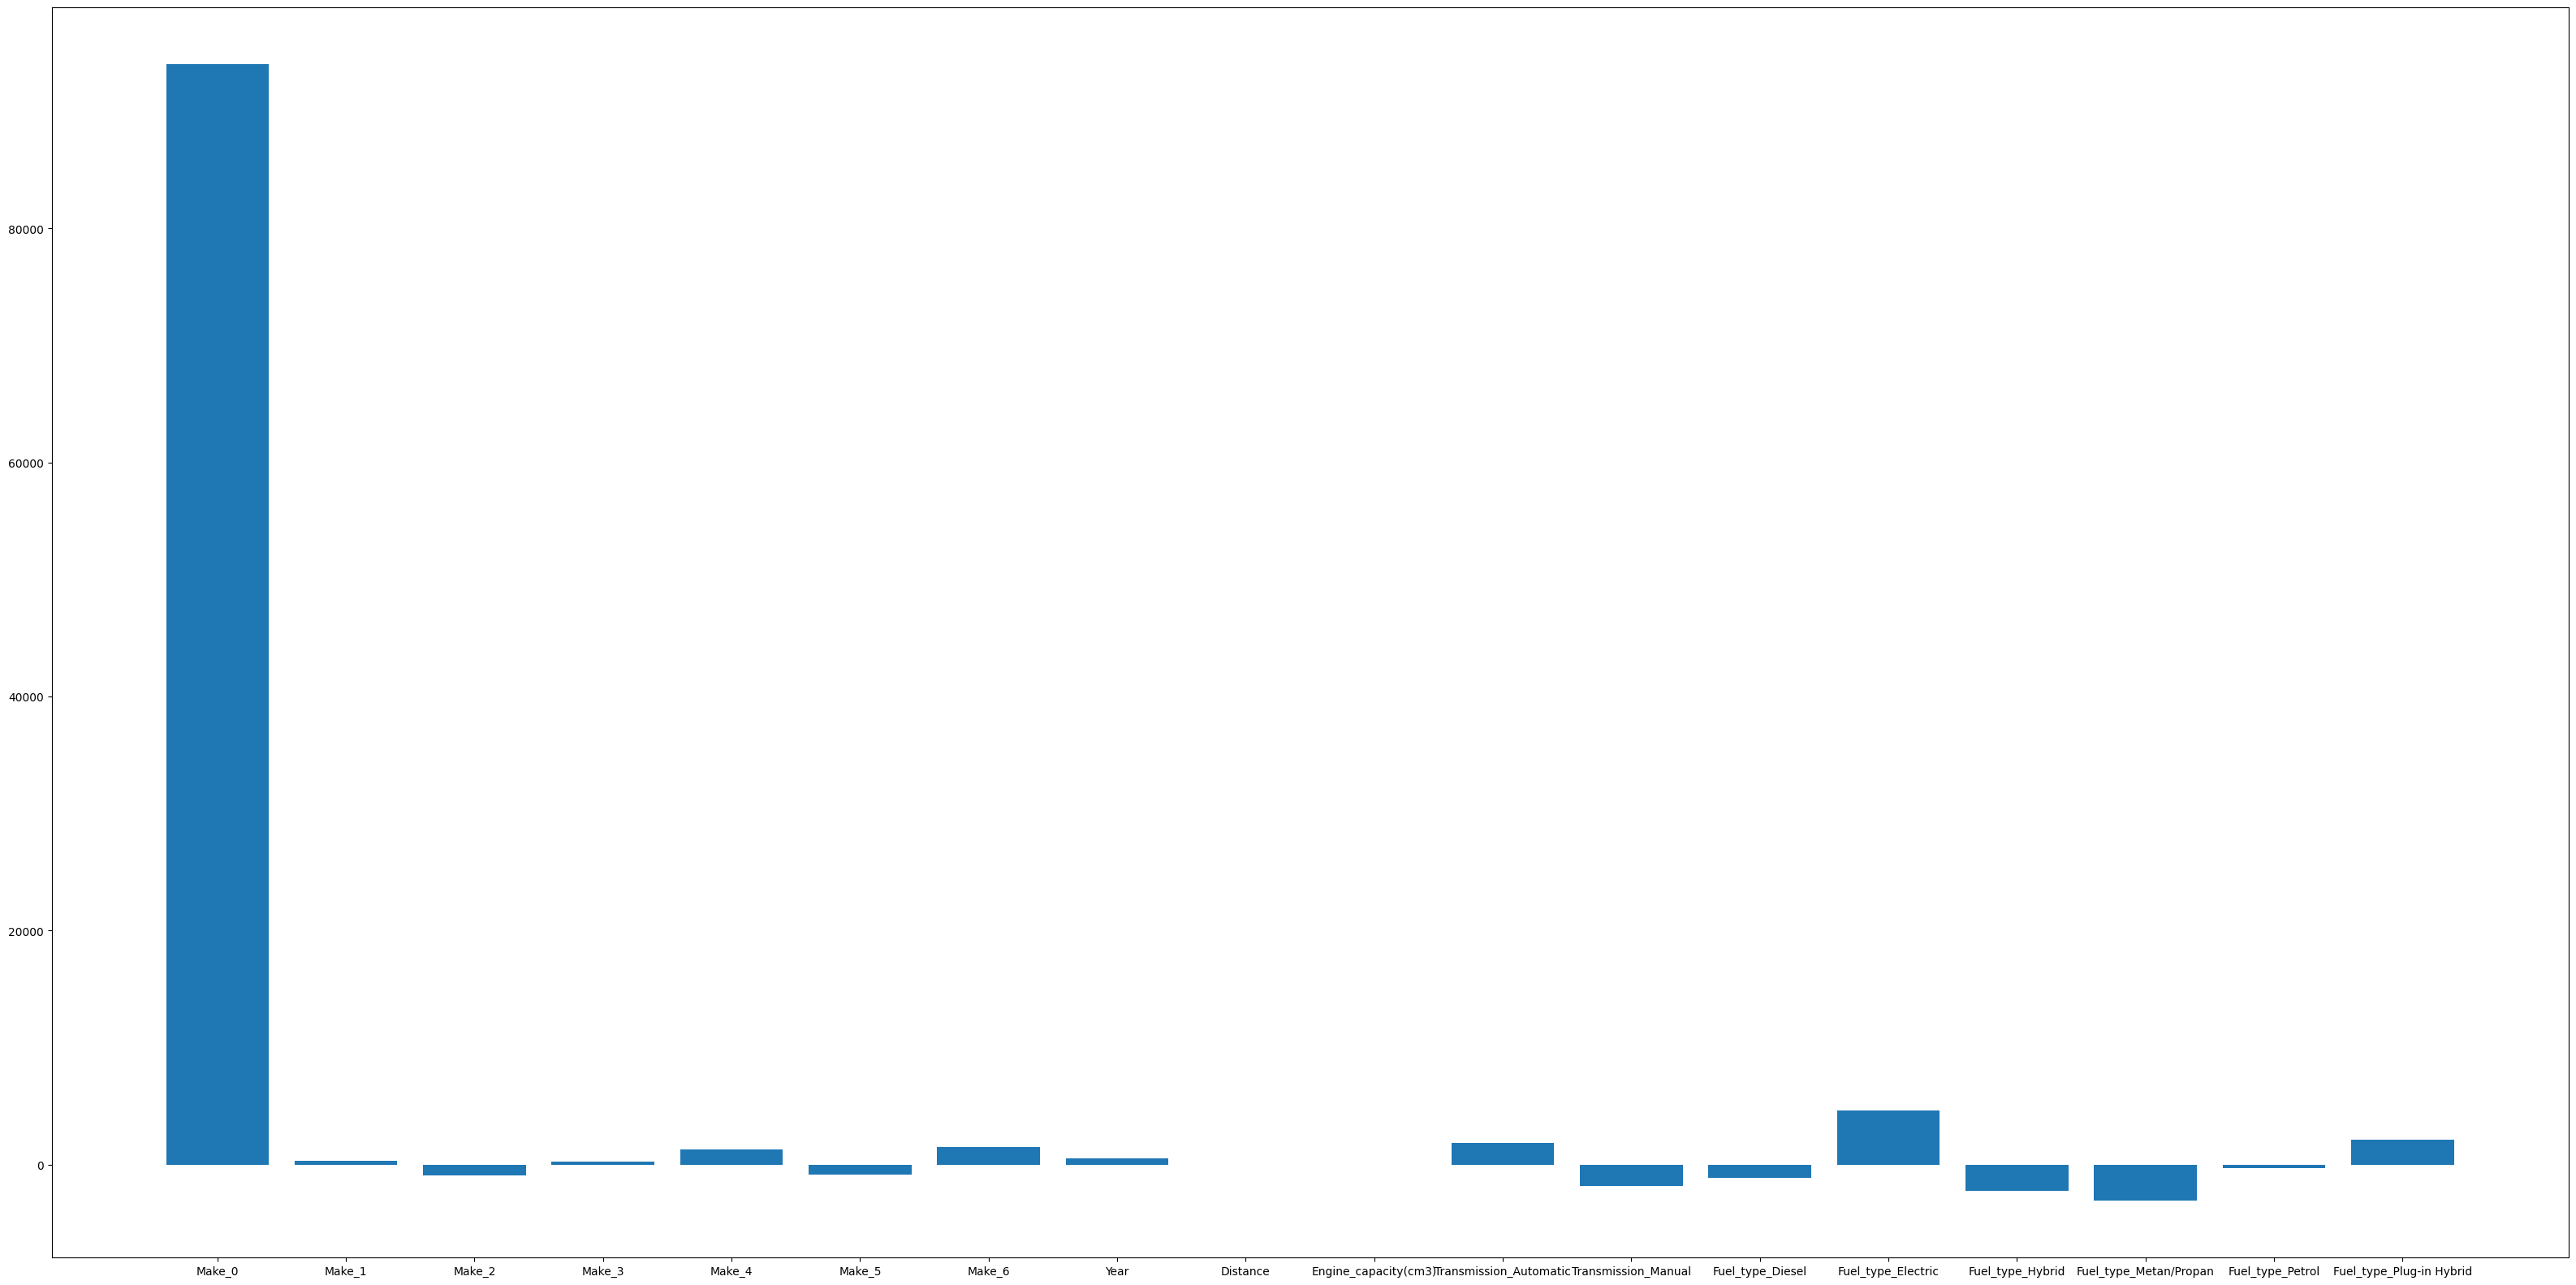

In [43]:
plt.figure(figsize=(40, 20))
plt.bar(x=X.columns,height = ypred)